# RSNA: Abnomional Trauma Detection -> Evaluation  Metric

**Objective:** Understand the evaluation metric proposed by the RSNA competition.

**The sample weights are as follows:**

* 1 for all healthy labels.
* 2 for low grade solid organ injuries (liver, spleen, kidney).
* 4 for high grade solid organ injuries.
* 2 for bowel injuries.
* 6 for extravasation.
* 6 for the auto-generated any_injury label.

#### Understanding the log-loss

_Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value._

**Reference:** https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a

It measures the performance of a model by quantifying the difference between predicted probabilities and actual values.

Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification), penalizing inaccurate predictions with higher values. Lower log-loss indicates better model performance.

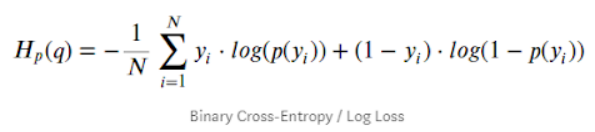

In [1]:
import numpy as np
import pandas as pd
import pandas.api.types
import sklearn.metrics

In [2]:
y_train = pd.read_csv("train.csv")
y_train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [4]:
Injuries = [y_train.columns[i] for i in range(1,15)]
Injuries

['bowel_healthy',
 'bowel_injury',
 'extravasation_healthy',
 'extravasation_injury',
 'kidney_healthy',
 'kidney_low',
 'kidney_high',
 'liver_healthy',
 'liver_low',
 'liver_high',
 'spleen_healthy',
 'spleen_low',
 'spleen_high',
 'any_injury']

### Code provided by the competition

* https://www.kaggle.com/code/metric/rsna-trauma-metric/notebook

In [5]:
def normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    # Normalize the sum of each row's probabilities to 100%.
    # 0.75, 0.75 => 0.5, 0.5
    # 0.1, 0.1 => 0.5, 0.5
    row_totals = df[group_columns].sum(axis=1)
    if row_totals.min() == 0:
        raise ParticipantVisibleError('All rows must contain at least one non-zero prediction')
    for col in group_columns:
        df[col] /= row_totals
    return df


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Pseudocode:
    1. For every label group (liver, bowel, etc):
        - Normalize the sum of each row's probabilities to 100%.
        - Calculate the sample weighted log loss.
    2. Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    3. Calculate the sample weighted log loss for the new label group
    4. Return the average of all of the label group log losses as the final score.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # Run basic QC checks on the inputs
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission.values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution.min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission.min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    # Calculate the label group log losses
    binary_targets = ['bowel', 'extravasation']
    triple_level_targets = ['kidney', 'liver', 'spleen']
    all_target_categories = binary_targets + triple_level_targets

    label_group_losses = []
    for category in all_target_categories:
        if category in binary_targets:
            col_group = [f'{category}_healthy', f'{category}_injury']
        else:
            col_group = [f'{category}_healthy', f'{category}_low', f'{category}_high']

        solution = normalize_probabilities_to_one(solution, col_group)

        for col in col_group:
            if col not in submission.columns:
                raise ParticipantVisibleError(f'Missing submission column {col}')
        submission = normalize_probabilities_to_one(submission, col_group)
        label_group_losses.append(
            sklearn.metrics.log_loss(
                y_true=solution[col_group].values,
                y_pred=submission[col_group].values,
                sample_weight=solution[f'{category}_weight'].values
            )
        )

    # Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    healthy_cols = [x + '_healthy' for x in all_target_categories]
    any_injury_labels = (1 - solution[healthy_cols]).max(axis=1)
    any_injury_predictions = (1 - submission[healthy_cols]).max(axis=1)
    any_injury_loss = sklearn.metrics.log_loss(
        y_true=any_injury_labels.values,
        y_pred=any_injury_predictions.values,
        sample_weight=solution['any_injury_weight'].values
    )

    label_group_losses.append(any_injury_loss)
    return np.mean(label_group_losses)

In order to correctly set up the metric we need to map the sample weights values for each category present in the training set. Doing this will ensure that the binary labels (0,1) change between the sample weights previously defined.

In [6]:
def create_training_solution(y_train):
    sol_train = y_train.copy()
    
    # bowel healthy|injury sample weight = 1|2
    sol_train['bowel_weight'] = np.where(sol_train['bowel_injury'] == 1, 2, 1)
    
    # extravasation healthy/injury sample weight = 1|6
    sol_train['extravasation_weight'] = np.where(sol_train['extravasation_injury'] == 1, 6, 1)
    
    # kidney healthy|low|high sample weight = 1|2|4
    sol_train['kidney_weight'] = np.where(sol_train['kidney_low'] == 1, 2, np.where(sol_train['kidney_high'] == 1, 4, 1))
    
    # liver healthy|low|high sample weight = 1|2|4
    sol_train['liver_weight'] = np.where(sol_train['liver_low'] == 1, 2, np.where(sol_train['liver_high'] == 1, 4, 1))
    
    # spleen healthy|low|high sample weight = 1|2|4
    sol_train['spleen_weight'] = np.where(sol_train['spleen_low'] == 1, 2, np.where(sol_train['spleen_high'] == 1, 4, 1))
    
    # any healthy|injury sample weight = 1|6
    sol_train['any_injury_weight'] = np.where(sol_train['any_injury'] == 1, 6, 1)
    
    return sol_train

In [8]:
solution_train = create_training_solution(y_train)
y_pred = y_train.copy()
y_pred[Injuries] = y_train[Injuries].mean().tolist()

no_scale_score = score(solution_train,y_pred,'patient_id')
print(f'Training score: {no_scale_score}')

Training score: 0.7860663285561644


"In summary, this code defines a scoring function for evaluating predictions for multiple label groups with different categories. The function takes the ground truth labels and participant's predictions, normalizes the probabilities, and then calculates the sample-weighted log loss for each label group and an additional derived label group. The final score is the average of all label group log losses."

**Code reference:** https://www.kaggle.com/code/jakebrusca/rsna23-weighted-mean-baseline